In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv("diabetes_for_test.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Outcome : y

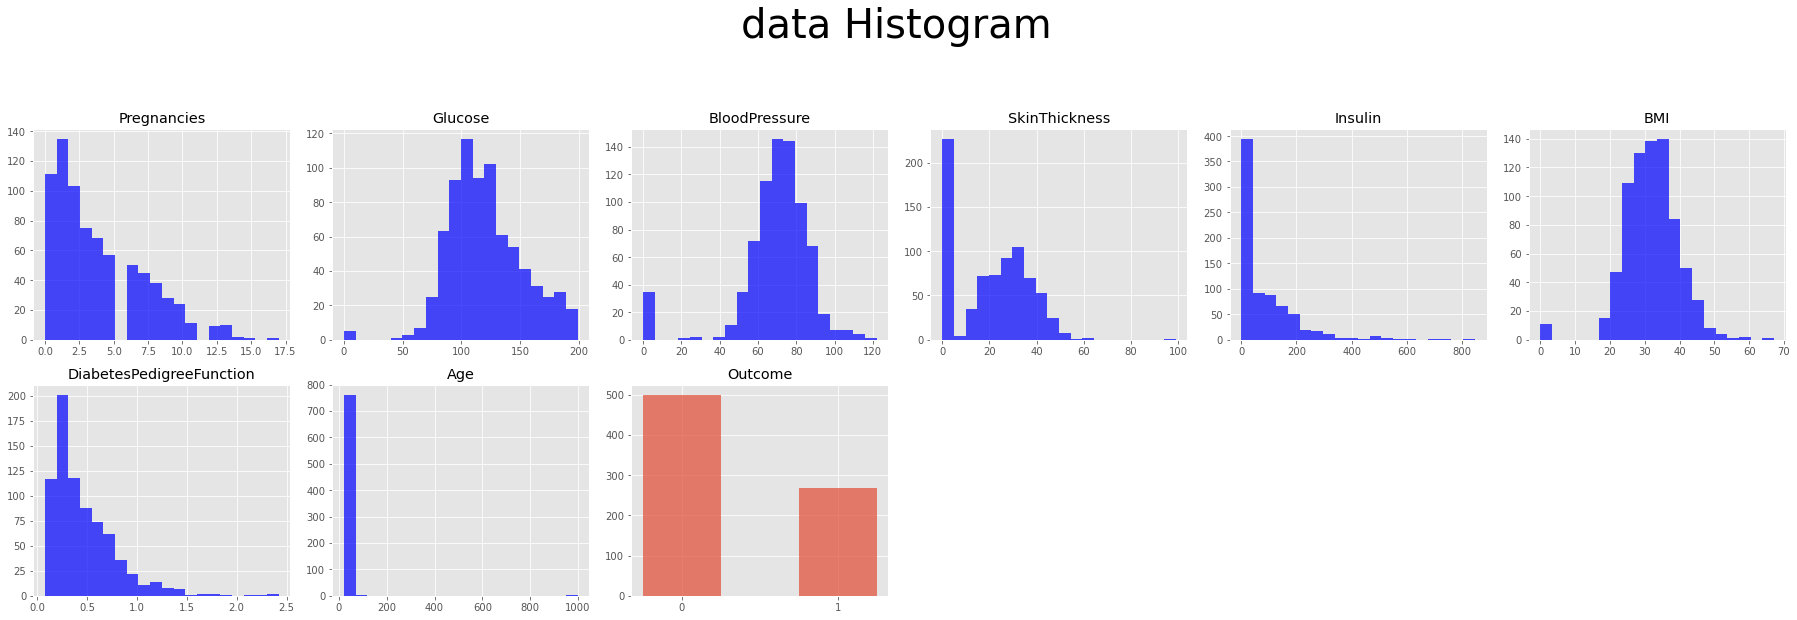

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(25,20))
plt.suptitle("data Histogram", fontsize=40)

cols=df.columns
for i in range(len(cols)):
    plt.subplot(5,6,i+1)
    plt.title(cols[i])
    if len(df[cols[i]].unique())>10:
        plt.hist(df[cols[i]], bins=20, color='b', alpha=0.7)
        
    else:
        temp=df[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<AxesSubplot:>

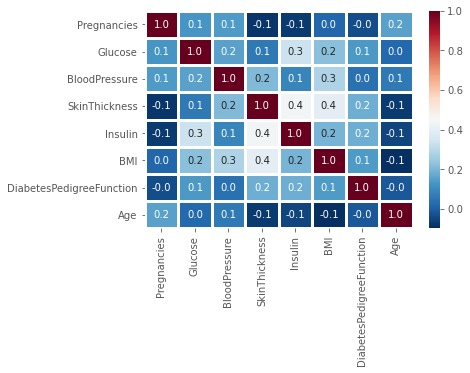

In [5]:
import seaborn as sns
df_cor=df.drop(columns=['Outcome']).corr(method='pearson')
sns.heatmap(df_cor, annot=True, fmt='.1f', cmap='RdBu_r', linewidth=3)

다중공선성은 없다고 판단

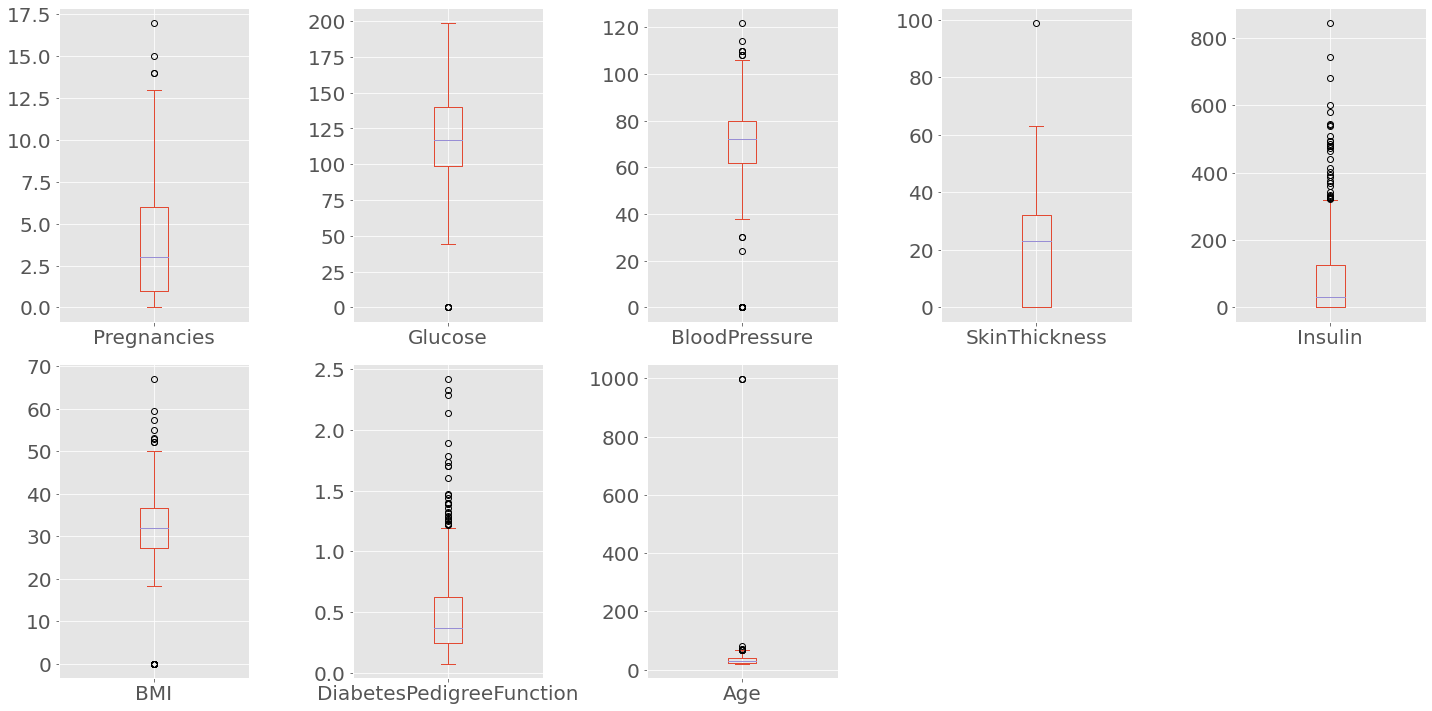

In [6]:
df.drop(columns='Outcome').plot(kind='box', subplots=True, layout=(2,5), figsize=(20,10), fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
#Age 이상치 중앙값 대체
index_1=df[df['Age']>200].index
df.loc[index_1, 'Age']=df['Age'].median()

#Glucose, BloodPressure중앙값 대체

In [8]:
index_2=df[df['Glucose']==0].index
df.loc[index_2, 'Glucose']=df['Glucose'].median()
index_3=df[df['BloodPressure']==0].index
df.loc[index_3, 'BloodPressure']=df['BloodPressure'].median()

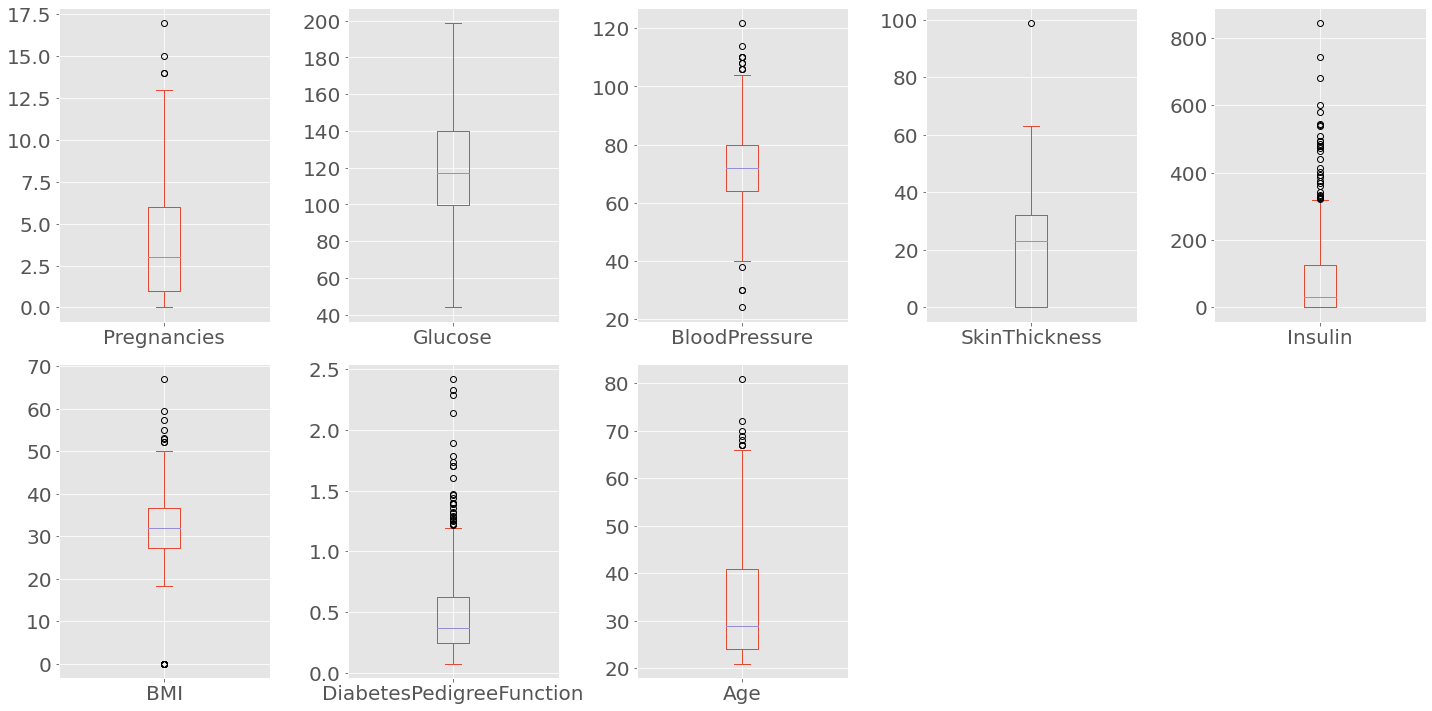

In [9]:
df.drop(columns='Outcome').plot(kind='box', subplots=True, layout=(2,5), figsize=(20,10), fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [11]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

X=df.drop(columns=['Outcome'])
y=df[['Outcome']]

ros=RandomOverSampler()
X_upsampling, y_upsampling=ros.fit_resample(X, y)

- 분류 알고리즘 구축

#70,30으로 나누지않고 교차검증 사용

In [13]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.svm as svm

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
from imblearn.over_sampling import SMOTE

log=LogisticRegression()
xgb=XGBClassifier(random_state=0)
svm_clf=svm.SVC(kernel='linear')

smote=SMOTE(random_state=0)

In [15]:
kfold = KFold()
def model_result(model):
    pred_li = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        
        X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)
        
        start = time.time()
        model.fit(X_train_resample, y_train_resample)
        end = time.time()
        
        pred = model.predict(X_test)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
        
    print(f"{end - start:.5f} sec")
    print(np.mean(pred_li))

In [16]:
model_result(log)

0.04683 sec
0.7514048043459807


In [17]:
model_result(xgb)

[16:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [18]:
model_result(svm_clf)

6.56064 sec
0.7605126899244546


로지스틱회귀 분석이 가장 빠르고 svm이 가장 성능이 좋다

- 차원축소 후 분류

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

smote=SMOTE(random_state=0)
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, test_size=0.3, random_state=2022)
scaler=StandardScaler()
X_train_s=scaler.fit_transform(X_train)
pca=PCA(n_components=8)
X_train_pca=pca.fit(X_train_s)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_[:5].sum())

[0.26110315 0.22613628 0.12025873 0.10650649 0.1016306  0.08197042
 0.05251497 0.04987936]
0.8156352463546328


In [20]:
def pca_model_result(model):
    pred_li=[]
    for train_index, test_index in kfold.split(X):
        X_train, X_test=X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test=y.iloc[train_index, :], y.iloc[test_index,:]
        
        X_train_resample, y_train_resample=smote.fit_resample(X_train, y_train)
        
        scaler=StandardScaler()
        X_train_res_s=scaler.fit_transform(X_train_resample)
        X_test_s=scaler.transform(X_test)
        
        pca=PCA(n_components=5)
        X_train_pca=pca.fit_transform(X_train_res_s)
        X_test_pca=pca.transform(X_test_s)
        
        start=time.time()
        model.fit(X_train_pca, y_train_resample)
        end=time.time()
        
        pred=model.predict(X_test_pca)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
    
    print(f'{end-start:.5f} sec')
    print(np.mean(pred_li))

In [21]:
pca_model_result(log)

0.00697 sec
0.7279093455564045


In [22]:
pca_model_result(xgb)

[16:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [23]:
pca_model_result(svm_clf)

0.04672 sec
0.7253034547152193
